Dataset  : Fashion : [MNIST datset](https://github.com/zalandoresearch/fashion-mnist)

Import required libraries

In [30]:
!pip install -U tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import tensorflow as tf

In [32]:
# Import tensorflow datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Support libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [33]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

Import the fashion MNIST dataset

In [34]:
dataset,metadata = tfds.load('fashion_mnist',as_supervised=True,with_info=True)
train_dataset,test_dataset = dataset['train'], dataset['test']

Labels available

In [35]:
class_names = metadata.features['label'].names
print("Class names : {}".format(class_names))

Class names : ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Exploring the data

In [36]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples: 10000


Preprocess the data

In [37]:
def normalize(images,labels):
  images = tf.cast(images,tf.float32)
  images/=255
  return images,labels

#The map function applies normalization to each element in train and test sets
train_dataset = train_dataset.map(normalize) 
test_dataset = test_dataset.map(normalize) 

#First loading of dataset takes time, caching helps to store it in memmory
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

Explore processed image

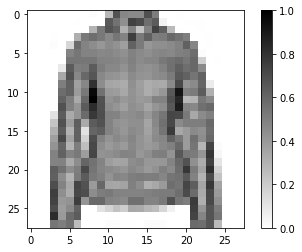

In [38]:
# Take single image and remove color dimension
for image, label in test_dataset.take(1):
    break
image = image.numpy().reshape((28,28))

#Plot the image
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

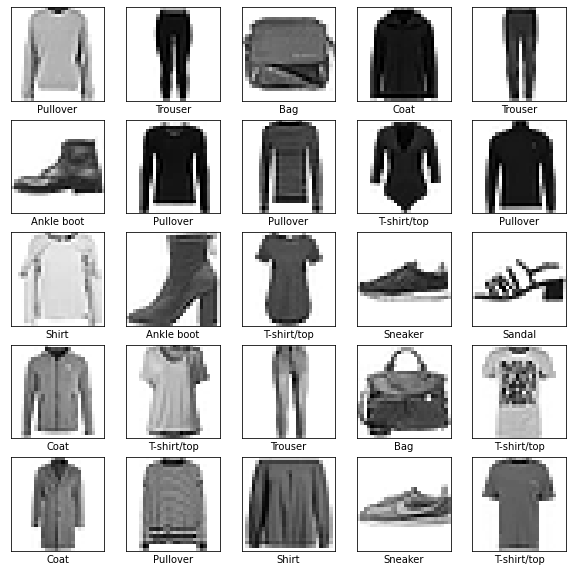

In [39]:
# verification of 25 images from train data with labels
plt.figure(figsize=(10,10))
for i,(image,label) in enumerate(train_dataset.take(25)):
  image = image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image,cmap = plt.cm.binary)
  plt.xlabel(class_names[label])
plt.show()

Buliding Layers


In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),padding='same',activation=tf.nn.relu,input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D((2,2),strides=2),
    tf.keras.layers.Conv2D(64,(3,3),padding='same',activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2,2),strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation=tf.nn.relu),
    tf.keras.layers.Dense(10,activation=tf.nn.softmax)
]) 

Compile the model

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

Train the model

In [42]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [43]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 89s 44ms/step - loss: 0.3968 - accuracy: 0.8557
Epoch 2/10
1875/1875 [==============================] - 71s 38ms/step - loss: 0.2587 - accuracy: 0.9062
Epoch 3/10
1875/1875 [==============================] - 69s 37ms/step - loss: 0.2144 - accuracy: 0.9194
Epoch 4/10
1875/1875 [==============================] - 70s 37ms/step - loss: 0.1812 - accuracy: 0.9317
Epoch 5/10
1875/1875 [==============================] - 69s 37ms/step - loss: 0.1564 - accuracy: 0.9418
Epoch 6/10
1875/1875 [==============================] - 69s 37ms/step - loss: 0.1299 - accuracy: 0.9521
Epoch 7/10
1875/1875 [==============================] - 69s 37ms/step - loss: 0.1125 - accuracy: 0.9582
Epoch 8/10
1875/1875 [==============================] - 69s 37ms/step - loss: 0.0970 - accuracy: 0.9638
Epoch 9/10
1875/1875 [==============================] - 69s 37ms/step - loss: 0.0793 - accuracy: 0.9705
Epoch 10/10
1875/1875 [==============================] - 69s 37m

Evaluate accuracy

In [44]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on the test set :',test_accuracy)

313/313 [==============================] - 6s 17ms/step - loss: 0.3123 - accuracy: 0.9187
Accuracy on the test set : 0.9186999797821045


Make predictions and explore

In [45]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [46]:
predictions.shape

(32, 10)

In [47]:
predictions[0]

array([3.9306506e-08, 1.6896427e-08, 1.6297707e-03, 6.7019723e-10,
       9.8311377e-01, 1.3970801e-09, 1.5256495e-02, 7.8281361e-11,
       2.0640902e-08, 1.7719197e-08], dtype=float32)

In [48]:
np.argmax(predictions[0])

4

In [49]:
test_labels[0]

4

Graph of all 32 predictions

In [50]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0],cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{}{:2.0f}% ({})".format(class_names[predicted_label],
                                      100*np.max(predictions_array),
                                      class_names[true_label]),
                                      color = color)
  
def plot_value_array(i, predictions_array, true_labels):
  predictions_array, true_label = predictions_array[i], true_labels[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10),predictions_array, color="#777777")
  plt.ylim([0,1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

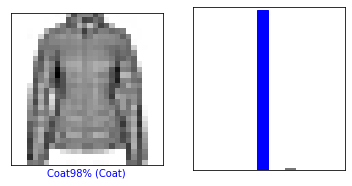

In [51]:
i=0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i,predictions,test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i,predictions,test_labels)

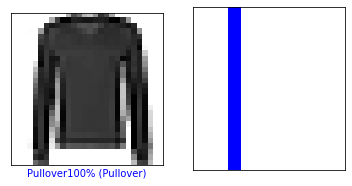

In [52]:
i=12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i,predictions,test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i,predictions,test_labels)

Moreee predictions

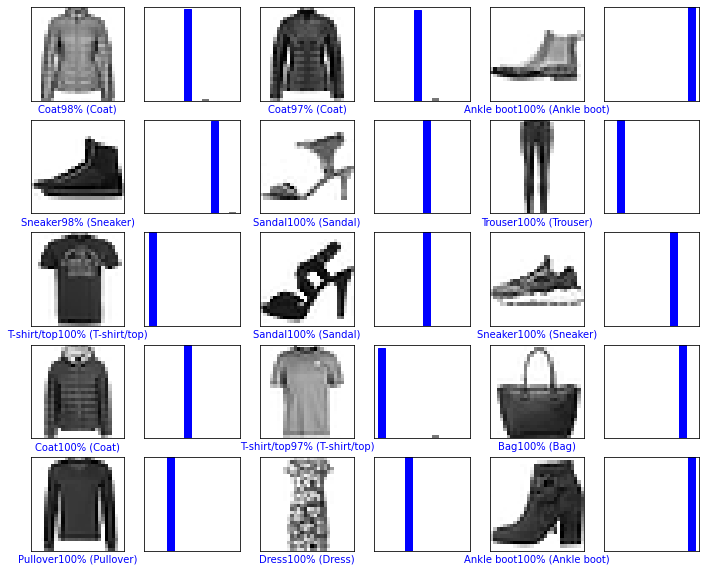

In [53]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize = (2*2*num_cols,2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i,predictions,test_labels,test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i,predictions,test_labels)

Image from test data set

In [54]:
img = test_images[0]
print(img.shape)

(28, 28, 1)


In [55]:
# tf.keras make prediction on batches so add to list
img = np.array([img])
print(img.shape)

(1, 28, 28, 1)


In [56]:
predictions_single = model.predict(img)
print(predictions_single)

[[3.9306357e-08 1.6896395e-08 1.6297675e-03 6.7019723e-10 9.8311377e-01
  1.3970775e-09 1.5256480e-02 7.8281215e-11 2.0640863e-08 1.7719163e-08]]


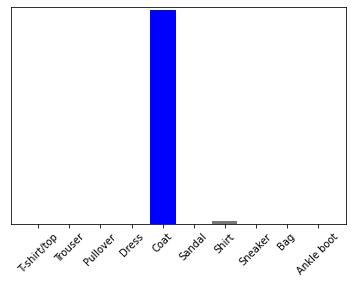

In [57]:
plot_value_array(0,predictions_single,test_labels)
_ = plt.xticks(range(10),class_names,rotation=45)

In [58]:
np.argmax(predictions_single)

4